In [2]:
import sys
sys.path.append("../")
from basic_functions import *
from scipy.special import erf
import numpy as np
import matplotlib.pyplot as plt

Plot log likelihood w/o selection function 

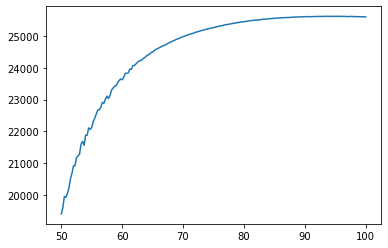

In [4]:
snr_th = 10
H0, likelihood = np.loadtxt('../LogLikelihoodSnrCut'+str(snr_th), unpack = True)
plt.plot(H0, likelihood)

Simulate detectable fraction by the analytic fit given by https://doi.org/10.3847/2041-8213/ab22be

1


Text(0, 0.5, 'Detectable Fraction')

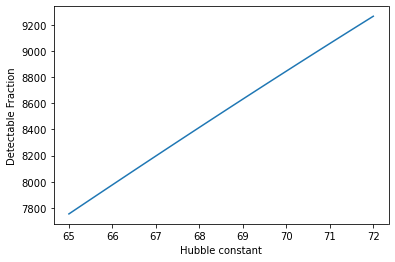

In [156]:
NSAMPLES = 10000
NEVENTS = 10000
m1 = 1.4
m2 = 1.4
theta = 1
z_samples = np.random.beta(3,9,NSAMPLES)*10
snr_th = 10
a = 1.63
b = 3.93
mc = m_chirp_from_m1_m2(m1, m2)
q = q_from_m1_m2(m1, m2)
lambda_tilde = 500
freq, psd = np.loadtxt('../CE_psd.txt', unpack=True)
z_array = np.linspace(0.0001,10.,2000)
dLarr_60=luminosity_distance(z_array,60,0.3)
deff_60 = np.interp(z_samples,z_array,dLarr_60)/theta
snr_60 = np.zeros(NSAMPLES)

for i in range(NSAMPLES):
    keys = ['m_chirp_z', 'q', 'lambda_tilde', 'effective_distance', 'z']
    m_chirp_z = mc*(1+z_samples[i])
    values = [m_chirp_z, q, lambda_tilde, deff_60[i], z_samples[i]]
    pars = dict(zip(keys, values))
    waveform = Waveform(pars, freq)
    snr_60[i] = waveform.snr(psd)
print (1)    
detectable_fraction_analytic = []
H0, likelihood = np.loadtxt('../LogLikelihoodSnrCut'+str(snr_th), unpack = True)
for _H0 in H0:
    dLarr=luminosity_distance(z_array,_H0,0.3)
    #print (len(z))
    deff = np.interp(z_samples,z_array,dLarr)
    snr = snr_60*deff_60/deff
    w=snr_th/snr
    detectable_fraction_analytic.append(np.sum(erf(a-b*w)-erf(a-b))) 

detectable_fraction_analytic=np.array(detectable_fraction_analytic)
plt.plot(H0, detectable_fraction_analytic)
plt.xlabel('Hubble constant')
plt.ylabel('Detectable Fraction')


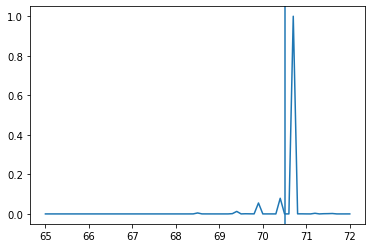

In [161]:
FNAME = '../data_seed_70.h5'
H0, likelihood = np.loadtxt('../LogLikelihoodSnrCut'+str(snr_th), unpack = True)
f = h5py.File(FNAME, "r")
snr = np.array(f['snr population'])
l = len(np.where(snr[:NEVENTS]>snr_th)[0])
likelihood = likelihood - l*np.log(detectable_fraction_analytic)
plt.plot(H0, np.exp(likelihood -np.max(likelihood)))
plt.axvline(x=70.5)

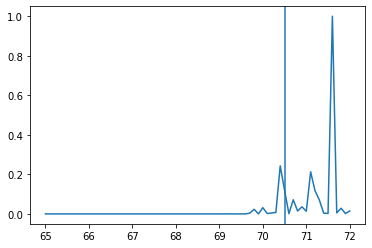

In [162]:
FNAME = '../data_seed_70.h5'
H0, likelihood = np.loadtxt('../LogLikelihood_w_MassPriorSnrCut'+str(snr_th), unpack = True)
f = h5py.File(FNAME, "r")
snr = np.array(f['snr population'])
l = len(np.where(snr[:NEVENTS]>snr_th)[0])
likelihood = likelihood - l*np.log(detectable_fraction_analytic)
plt.plot(H0, np.exp(likelihood -np.max(likelihood)))
plt.axvline(x=70.5)

This is using a model whilc assumes all neutron stars are of 1.4 solar mass which is clearly not correct. So we try to calculate the detectable fraction in proper way.

We generate a set of detected samples in DetectedSamples.py

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import corner
from scipy.stats import beta

ndim = 3
f = h5py.File('/home/pratyusava.baral/3G_Cosmo/NSNSEOS/Selection_Function/Samples.h5', 'r')

z_fiducial = np.array(f['z_fiducial'])
effective_distance_fiducial = np.array(f['effective_distance_fiducial'])

z_detected = np.array(f['z_detected'])
effective_distance_detected = np.array(f['effective_distance_detected'])

m_chirp_fiducial = np.array(f['m_chirp_fiducial'])
m_chirp_detected = np.array(f['m_chirp_detected'])


Dat=np.array([z_fiducial, effective_distance_fiducial, m_chirp_fiducial]).T 
Dat_detected=np.array([z_detected, effective_distance_detected,m_chirp_detected]).T  
labels = ['z', 'd_eff','m_chirp']    
tr=corner.corner(Dat,labels=labels,smooth=1.2,quantiles=[0.1,0.5,0.9],show_titles=True,title_kwargs={"fontsize": 12},use_math_text=True,hist_kwargs={"density": True})
tr1=corner.corner(Dat_detected,labels=labels,smooth=1.2,color='r',fig=tr,hist_kwargs={"density": True})#weights= 1/beta(3,9).pdf(z_detected/10)/beta(3,9).pdf(z_detected/127),

axes = np.array(tr.axes).reshape((ndim, ndim))
plt.show()
f.close()          


In [138]:
from scipy.stats import uniform,beta
n_draw = 1000000
z_fiducial_pdf = uniform(loc = 0.0001, scale = 10)
effective_distance_fiducial_pdf = uniform(loc = 10, scale = 127)
m_chirp_fiducial_pdf = uniform(loc = 1, scale = 0.4)
def calc_detectable_fraction(H0, z_fiducial_pdf, effective_distance_fiducial_pdf, m_chirp_fiducial_pdf, z_detected, effective_distance_detected, m_chirp_detected, n_draw):
    z_array = np.linspace(0.0001,10.,2000)
    luminosity_distance_array = luminosity_distance(z_array, H0, 0.3)
    cosmo_true_z_luminosity_distance_list = np.array([z_array, luminosity_distance_array])
    luminosity_distance_from_z_detected = np.interp(z_detected, cosmo_true_z_luminosity_distance_list[0], cosmo_true_z_luminosity_distance_list[1])
    theta = luminosity_distance_from_z_detected/effective_distance_detected
    population_prior = beta(3,9).pdf(z_detected/10)*beta(2,4).pdf(theta) * theta * uniform(loc = 1, scale = 0.4).pdf(m_chirp_detected)
    detectable_fraction_mean = np.sum(population_prior/(z_fiducial_pdf.pdf(z_detected)*effective_distance_fiducial_pdf.pdf(effective_distance_detected)* m_chirp_fiducial_pdf.pdf(m_chirp_detected)))/n_draw
    detectable_fraction_sigma = np.sum(population_prior**2/(z_fiducial_pdf.pdf(z_detected)*effective_distance_fiducial_pdf.pdf(effective_distance_detected)* m_chirp_fiducial_pdf.pdf(m_chirp_detected))**2)/n_draw**2 - detectable_fraction_mean**2/n_draw
    return detectable_fraction_mean, detectable_fraction_sigma, (detectable_fraction_mean/detectable_fraction_sigma)**2

In [139]:
print (calc_detectable_fraction(80.5, z_fiducial_pdf, effective_distance_fiducial_pdf, m_chirp_fiducial_pdf, z_detected, effective_distance_detected, m_chirp_detected, n_draw))

(93.77476222321461, 0.16636404137962701, 317726.1933174235)


Text(0, 0.5, 'Detectable Fraction')

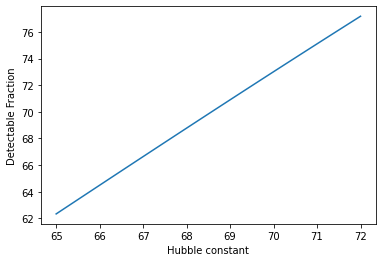

In [164]:
snr_th = 10
detectable_fraction = []
H0, likelihood = np.loadtxt('../LogLikelihood_w_MassPriorSnrCut'+str(snr_th), unpack = True)
for _H0 in H0:
    detectable_fraction.append(calc_detectable_fraction(_H0, z_fiducial_pdf, effective_distance_fiducial_pdf, m_chirp_fiducial_pdf, z_detected, effective_distance_detected, m_chirp_detected, n_draw)[0]) 
#print (snr_60[0],snr[0],4.9537786741644885)
detectable_fraction_mean = np.array(detectable_fraction)
plt.plot(H0, detectable_fraction_mean)
plt.xlabel('Hubble constant')
plt.ylabel('Detectable Fraction')

2979


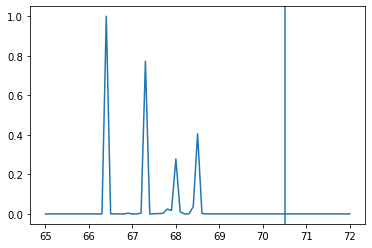

In [165]:
NEVENTS = 10000
H0, likelihood = np.loadtxt('../LogLikelihoodSnrCut'+str(snr_th), unpack = True)
FNAME = '../data_seed_70.h5'
f = h5py.File(FNAME, "r")
snr = np.array(f['snr population'])
l = len(np.where(snr[:NEVENTS]>snr_th)[0])
print (l)
likelihood = likelihood - l*np.log(detectable_fraction)
plt.plot(H0, np.exp(likelihood -np.max(likelihood)))
plt.axvline(x=70.5)

[65.  65.1 65.2 65.3 65.4 65.5 65.6 65.7 65.8 65.9 66.  66.1 66.2 66.3
 66.4 66.5 66.6 66.7 66.8 66.9 67.  67.1 67.2 67.3 67.4 67.5 67.6 67.7
 67.8 67.9 68.  68.1 68.2 68.3 68.4 68.5 68.6 68.7 68.8 68.9 69.  69.1
 69.2 69.3 69.4 69.5 69.6 69.7 69.8 69.9 70.  70.1 70.2 70.3 70.4 70.5
 70.6 70.7 70.8 70.9 71.  71.1 71.2 71.3 71.4 71.5 71.6 71.7 71.8 71.9
 72. ]
2979


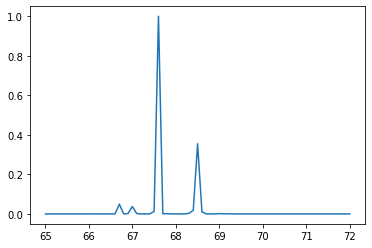

In [166]:
NEVENTS = 10000
H0, likelihood = np.loadtxt('../LogLikelihood_w_MassPriorSnrCut'+str(snr_th), unpack = True)
print (H0)
FNAME = '../data_seed_70.h5'
f = h5py.File(FNAME, "r")
snr = np.array(f['snr population'])
l = len(np.where(snr[:NEVENTS]>snr_th)[0])
print (l)
likelihood = likelihood - l*np.log(detectable_fraction)
plt.plot(H0, np.exp(likelihood -np.max(likelihood)))
plt.axvline(x=70.5)